# Importing the Libraries Necessary for the Work

The following work requires several libraries for the tasks. Below is the list of libraries used:

- **geopandas**: For working with geospatial data and creating GeoDataFrames.
- **numpy**: For numerical operations.
- **matplotlib.pyplot**: For creating plots and visualizations.
- **shapely.geometry**: For working with geometric objects.
- **rasterio**: For reading raster data, such as satellite images.


In [61]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import rasterio 
from rasterio.plot import show
from shapely.geometry import Point
import numpy as np 


# Load the Shapefile


In [62]:
batiment = gpd.read_file('Sidi_Bou_Othmane\\Batiment.shp')
arbre = gpd.read_file('Sidi_Bou_Othmane\\Arbre.shp')
trottoire = gpd.read_file('Sidi_Bou_Othmane\\Trottoire.shp')
cactus=gpd.read_file('Sidi_Bou_Othmane\\Cactus.shp')
route=gpd.read_file('Sidi_Bou_Othmane\\Routes.shp')

# Concatenate all GeoDataFrames into a single GeoDataFrame


In [63]:
gdf = gpd.GeoDataFrame(pd.concat([batiment, arbre, trottoire, cactus, route], ignore_index=True))

C:\Users\sayeh omar\AppData\Local\Temp\ipykernel_13616\1906206074.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = gpd.GeoDataFrame(pd.concat([batiment, arbre, trottoire, cactus, route], ignore_index=True))


In [64]:
gdf.crs

<Projected CRS: PROJCS["WGS_1984_UTM_Zone_32N",GEOGCS["WGS 84",DAT ...>
Name: WGS_1984_UTM_Zone_32N
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Plotting the Shapefiles

C:\Users\sayeh omar\AppData\Local\Temp\ipykernel_13616\293231655.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


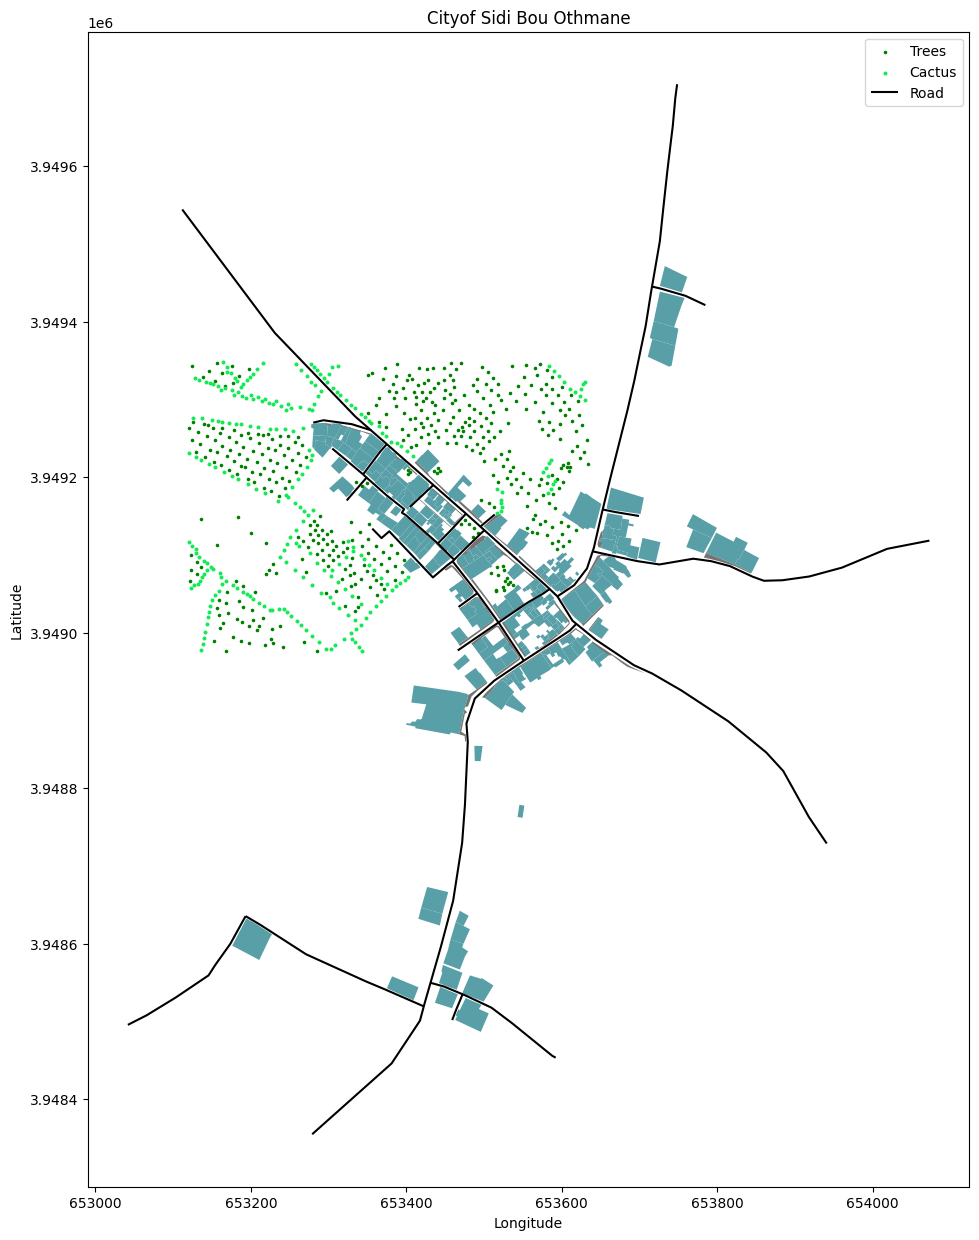

In [65]:
fig,ax=plt.subplots(1,figsize=(15,15))
batiment.plot(ax=ax, color='#589fa7', label='Buildings')
arbre.plot(ax=ax,color='green',label='Trees',markersize=2.5)
trottoire.plot(ax=ax,color='#757473',label='Sidewalk')
cactus.plot(ax=ax,color='#16e958',label='Cactus',markersize=3.5)
route.plot(ax=ax,color='black',label='Road')

ax.set_title('Cityof Sidi Bou Othmane')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.show()

# Create a GeoDataFrame with a single Point representing the center of the geometry

In [66]:
geometry = gdf['geometry']
center_point = Point(geometry.centroid.x.mean(), geometry.centroid.y.mean())
center_gdf = gpd.GeoDataFrame(geometry=[center_point], crs=gdf.crs)

# Plotting the satellite image using rasterio


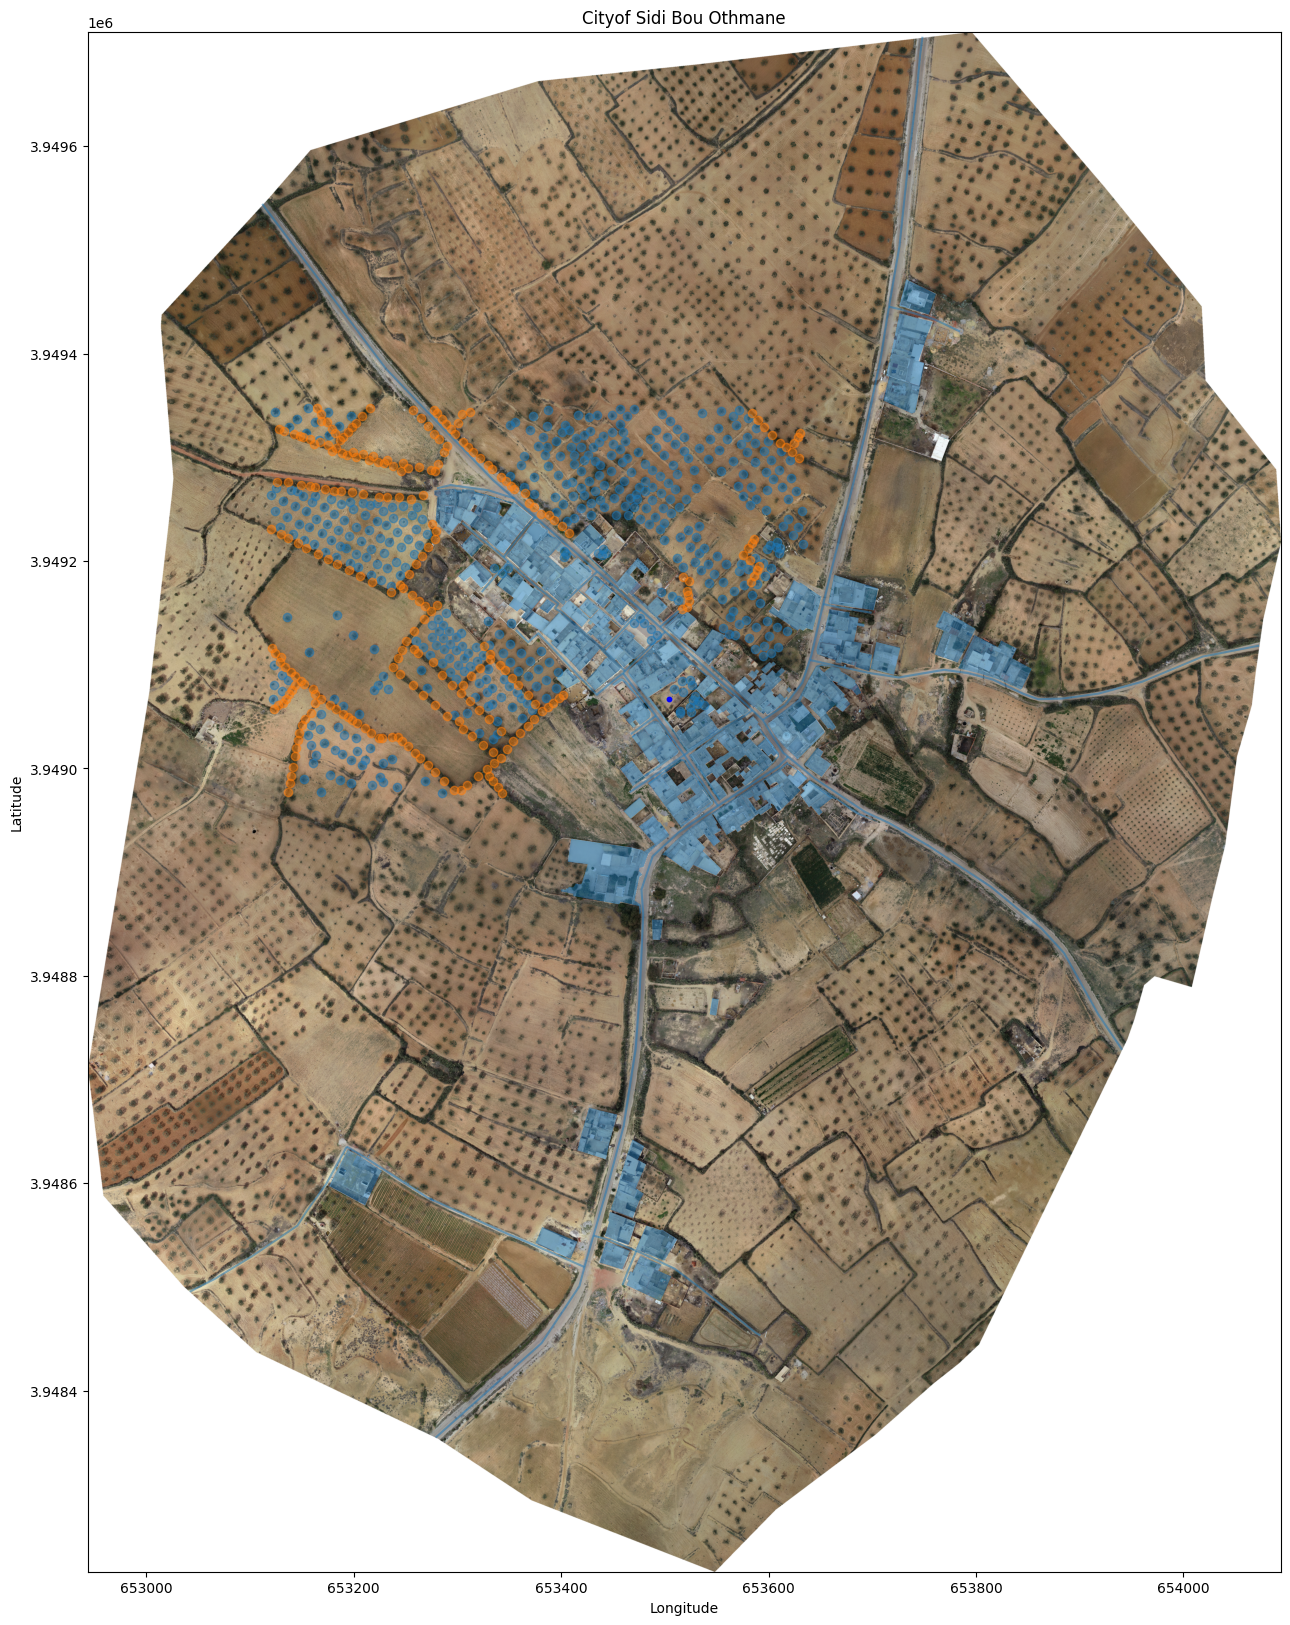

In [67]:
image_path = 'Sidi_Bou_Othmane\\Ortho_Sidi_Bou_Othmane_20cm.tif'
with rasterio.open(image_path) as src:
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 20))

    # Plot the raster image
    show(src, cmap='viridis', ax=ax)

    # Plot each shapefile separately on top of the raster
    for gdf in [batiment, arbre, trottoire, cactus, route]:
        gdf.plot(ax=ax, alpha=0.5)

    # Plot the center point for reference
    center_gdf.plot(ax=ax, color='blue', markersize=10)

    ax.set_title('Cityof Sidi Bou Othmane')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    

    plt.show()

# Positining the 5G Antennas

The following work descirbe the process of choosing the position of the 5G Antennas

- **Drop rows with None geometries**: To avoid errors when loading the geometries .
- **Create a GeoDataFrame for the convex hull around all buildings**: This process creates a convex hull (zone of from the edegs of the buildings) .
- **Create a grid of points within the convex hull**: This process creates a grid of points all over the convex hull .
- **Check the validation of points**: Check if the point is within the convex hull and has a non-overlapping buffer zone.



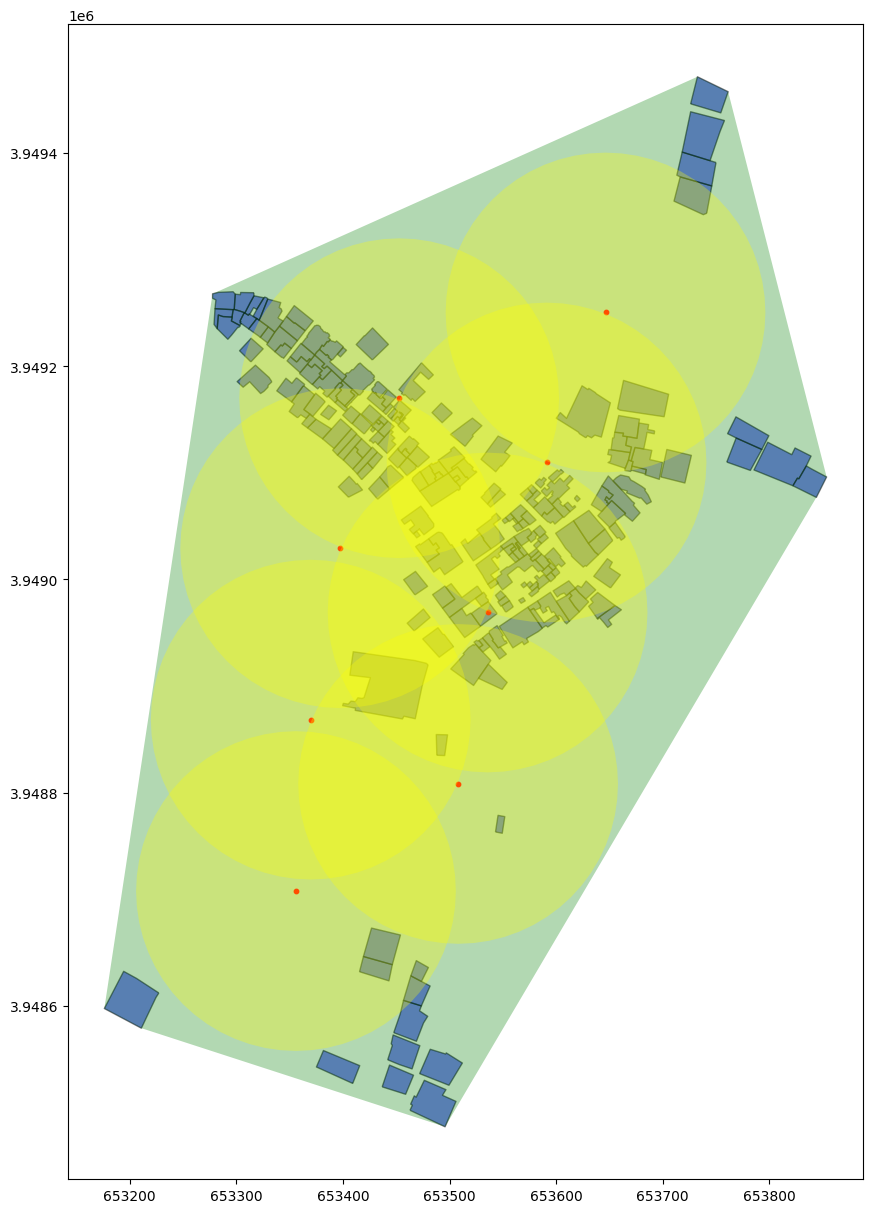

In [68]:
# Drop rows with None geometries
batiment = batiment[~batiment.geometry.isna()]

# Define the antenna range (signal coverage) and buffer zone
antenna_range = 150  # in meters

# Create a GeoDataFrame for the convex hull around all buildings
convex_hull = gpd.GeoDataFrame(geometry=[batiment.unary_union.convex_hull], crs=batiment.crs)

# Create an empty GeoDataFrame for antennas
antenna_gdf = gpd.GeoDataFrame(geometry=[], crs=batiment.crs)

# Create a grid of points within the convex hull
xmin, ymin, xmax, ymax = convex_hull.geometry.total_bounds
x_points = np.linspace(xmin, xmax, 50)
y_points = np.linspace(ymin, ymax, 50)
grid_points = [Point(x, y) for x in x_points for y in y_points]

# Function to check if a point is within the convex hull and has a non-overlapping buffer zone
def is_valid_point(point, existing_antennas):
    buffer_zone = point.buffer(antenna_range)
    for existing_antenna in existing_antennas.geometry:
        if buffer_zone.intersects(existing_antenna):
            return False
    return convex_hull.geometry.contains(buffer_zone).all()

# Create antennas with non-overlapping buffer zones
for point in grid_points:
    if is_valid_point(point, antenna_gdf):
        antenna_gdf = gpd.GeoDataFrame(geometry=list(antenna_gdf.geometry) + [point], crs=batiment.crs)

# Plot the original geometries, the buildings, the convex hull, the 5G antennas, and their buffer zones
fig, ax = plt.subplots(1, figsize=(15, 15))
batiment.plot(ax=ax, alpha=0.5, color='blue', edgecolor='black')
convex_hull.plot(ax=ax, alpha=0.3, color='green')
antenna_gdf.plot(ax=ax, marker='o', color='red', markersize=10)
for _, antenna in antenna_gdf.iterrows():
    buffer_zone = antenna['geometry'].buffer(antenna_range)
    gpd.GeoSeries(buffer_zone).plot(ax=ax, color='yellow', alpha=0.3)

plt.show()

- **Exporting the 5G Antennas**


In [69]:
antenna_gdf.to_file('5G Antennas.shp')


# Plotting the 5G Antennas with GDF on the Raster


C:\Users\sayeh omar\AppData\Local\Temp\ipykernel_13616\1243290159.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


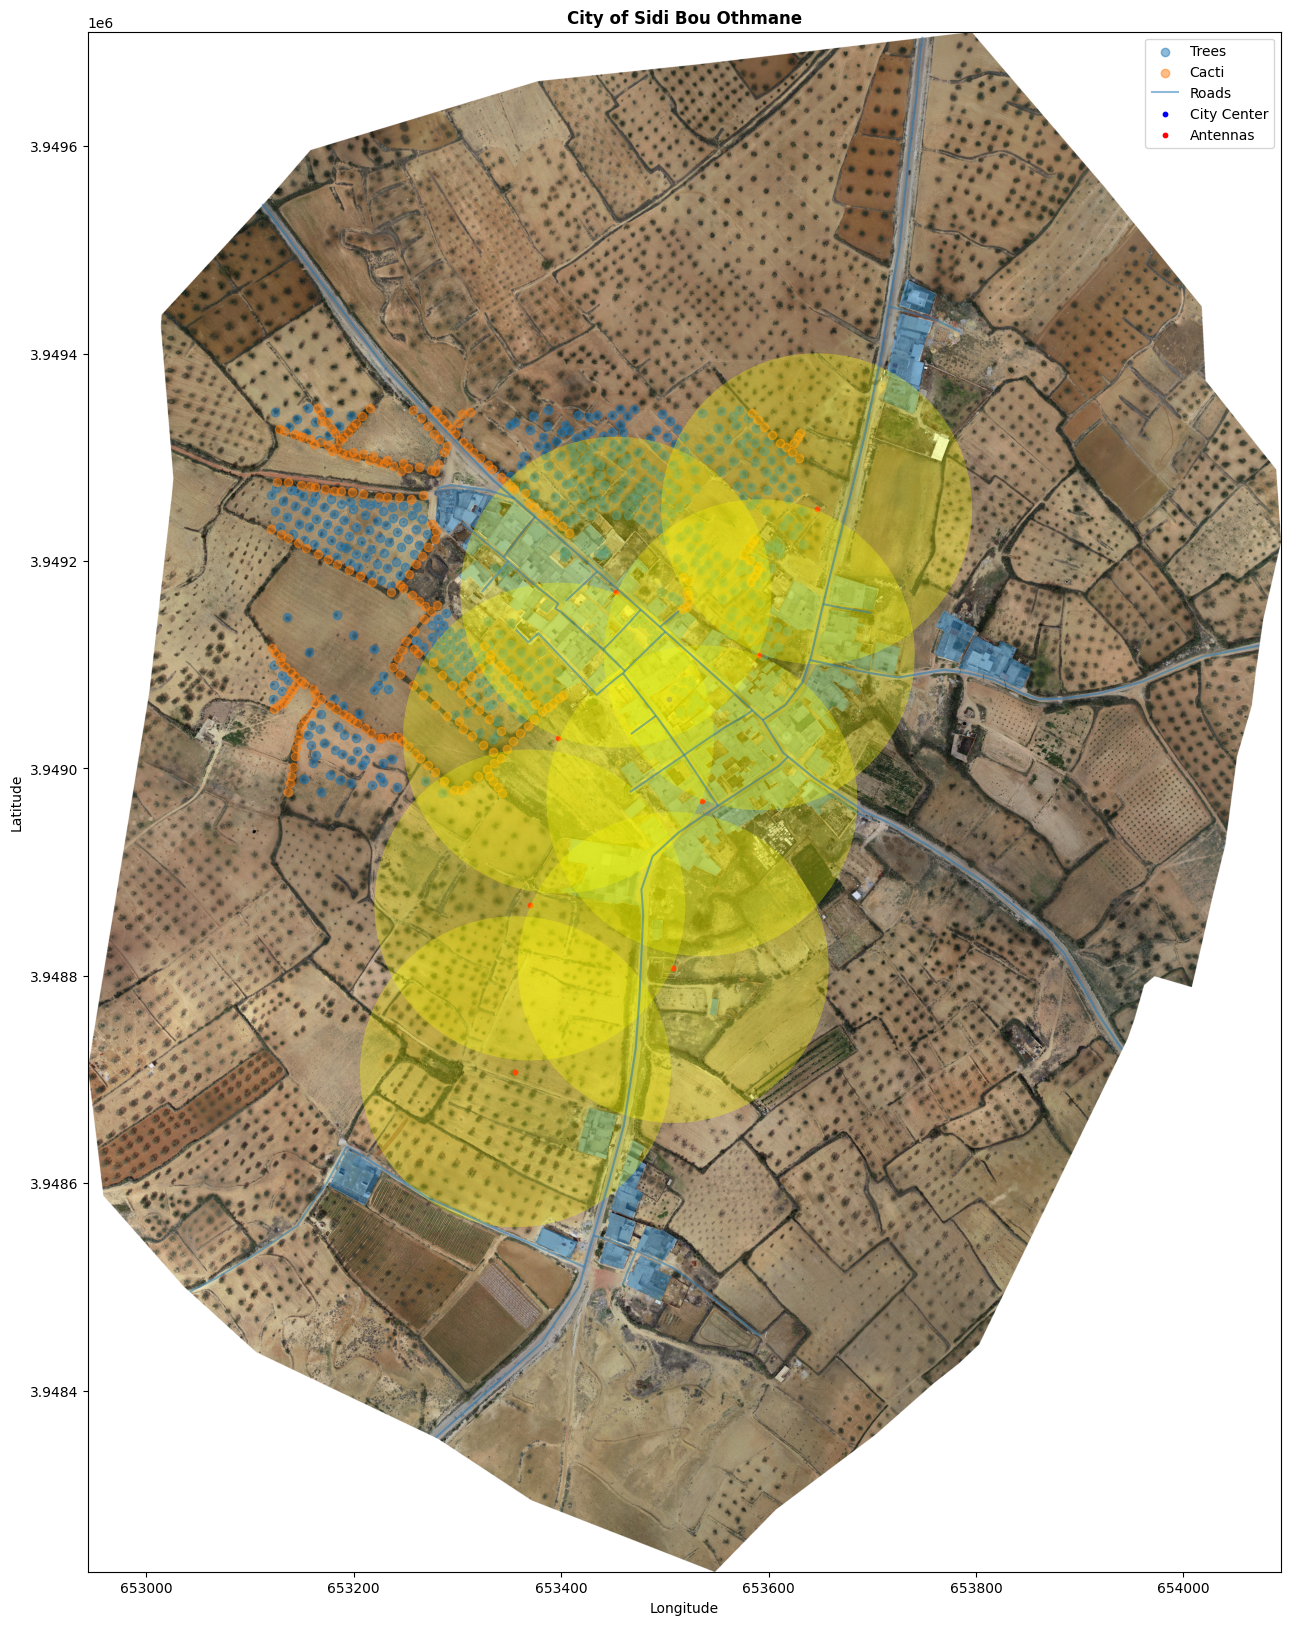

In [70]:
# Load the satellite image using rasterio
image_path = 'Sidi_Bou_Othmane\\Ortho_Sidi_Bou_Othmane_20cm.tif'
with rasterio.open(image_path) as src:
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 20))

    # Plot the raster image
    show(src, cmap='viridis', ax=ax, title='City of Sidi Bou Othmane')

    # Plot each shapefile separately on top of the raster
    for gdf, label in zip([batiment, arbre, trottoire, cactus, route], ['Buildings', 'Trees', 'Sidewalks', 'Cacti', 'Roads']):
        gdf.plot(ax=ax, alpha=0.5, label=label)

    # Plot the center point for reference
    center_gdf.plot(ax=ax, color='blue', markersize=10, label='City Center')

    antenna_gdf.plot(ax=ax, marker='o', color='red', markersize=10, label='Antennas')
    for _, antenna in antenna_gdf.iterrows():
        buffer_zone = antenna['geometry'].buffer(antenna_range)
        gpd.GeoSeries(buffer_zone).plot(ax=ax, color='yellow', alpha=0.3, label='Antenna Buffer Zone')

   

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()

    # Show the plot
    plt.show()